# DSCI 100 Group 2 Project Proposal

## Heart Failure Prediction

### Jason Cao, Tyler Wallis, Mahdia Mahfuz



### Introduction

Cardiovascular diseases (CVDs) are the largest contributor to death globally (about 31%, or 17.9 million lives per year). This data set observes a range of variables related to the heart that could potentially predict a heart disease, including cholesterol levels, types of chest pain, blood pressure and sugar, as well as variables regarding age, sex, and the presence or absence of heart disease. This project will attempt to answer the following predictive question: what variable(s) most strongly predict(s) presence of a heart disease?

The dataset we will be using, which is found on Kaggle [here][1], is the combination of five different datasets within the UCI Machine Learning Repository’s Heart Disease Data Set found [here][2]. Although the dataset contains 76 attributes, we will be using a subset of 8 that other published experiments have used as well. The attributes are described as follows:

[1]: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
[2]: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

1. Age: age of patient (years)
2. Sex: sex (1 = male, 0 = female)
3. RestingBP: resting blood pressure (mm/Hg)
4. Cholesterol: Serum cholesterol (mg/dl)
5. FastingBS: fasting blood sugar (1 if FastingBS > 120 mg/dl, otherwise 0)
6. MaxHR: maximum heart rate achieved (value between 60 and 202)
7. ExerciseAngina: exercise induced angina (1 = Yes, 0 = No)
8. HeartDisease: output/prediction (1 = heart disease, 0 = normal)

### Preliminary Exploratory Data Analysis

In [1]:
import altair as alt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

alt.data_transformers.disable_max_rows()
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [2]:
url = "https://raw.githubusercontent.com/caojason/dsci-100-group-2/main/data/heart.csv"
heart_data = pd.read_csv(url)
heart_data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


Table 1 (above): A view of our dataset of interest before it has been wrangled.

We transform the variables "Sex" and "ExerciseAngina" into binary values in order for them to be able to be fed into our data pipline.

In [3]:
#select columns/variables of interest
heart_data_filtered = heart_data[
    ["Age","Sex","RestingBP","Cholesterol","FastingBS","MaxHR","ExerciseAngina","HeartDisease"]
]

#turn all variables into int64
heart_data_filtered["Sex"] = heart_data_filtered["Sex"].apply(
lambda x: 1 if (x == "M") else 0
)

heart_data_filtered["ExerciseAngina"] = heart_data_filtered["ExerciseAngina"].apply(
lambda x: 1 if (x == "Y") else 0
)

#remove NaN values
heart_data_nozeroes = heart_data_filtered[
    (heart_data["Cholesterol"] > 0) &
    (heart_data["RestingBP"] > 0) &
    (heart_data["MaxHR"] > 0)
]
heart_data_nozeroes

/tmp/ipykernel_19241/2417064824.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_data_filtered["Sex"] = heart_data_filtered["Sex"].apply(
/tmp/ipykernel_19241/2417064824.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_data_filtered["ExerciseAngina"] = heart_data_filtered["ExerciseAngina"].apply(


,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,HeartDisease
0,40,1,140,289,0,172,0,0
1,49,0,160,180,0,156,0,1
2,37,1,130,283,0,98,0,0
3,48,0,138,214,0,108,1,1
4,54,1,150,195,0,122,0,0
...,...,...,...,...,...,...,...,...
913,45,1,110,264,0,132,0,1
914,68,1,144,193,1,141,0,1
915,57,1,130,131,0,115,1,1
916,57,0,130,236,0,174,0,1


Table 2 (above): Our sample dataset after it has been wrangled. It now only shows variables of interest, has all variables as int64-type data, and all NaN values have been removed.

In [4]:
heart_data_nozeroes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             746 non-null    int64
 1   Sex             746 non-null    int64
 2   RestingBP       746 non-null    int64
 3   Cholesterol     746 non-null    int64
 4   FastingBS       746 non-null    int64
 5   MaxHR           746 non-null    int64
 6   ExerciseAngina  746 non-null    int64
 7   HeartDisease    746 non-null    int64
dtypes: int64(8)
memory usage: 52.5 KB


We can see that our filtered dataset has 746 observations for each attribute and missing data has been removed.

In [5]:
heart_data_training, heart_data_testing = train_test_split(
    heart_data_nozeroes, test_size=0.25, random_state=1234
)
heart_data_training

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,HeartDisease
594,58,1,160,256,1,113,1,1
824,37,1,130,250,0,187,0,0
199,57,0,130,308,0,98,0,0
62,45,1,140,224,0,144,0,0
730,49,0,134,271,0,162,0,0
...,...,...,...,...,...,...,...,...
544,61,0,140,298,1,120,1,0
204,56,1,130,184,0,100,0,0
53,41,0,130,245,0,150,0,0
417,44,1,130,209,0,127,0,0


Table 3 (above): A view of our training data set, which was derived from the original, wrangled data shown in Table 2.

In [6]:
chol_plot = (
    alt.Chart(heart_data_training, title="Training Set Distribution of Cholesterol")
    .mark_bar()
    .encode(
        x=alt.X("Cholesterol",bin=alt.Bin(maxbins=30),title="Cholesterol (mg/dl)",scale=alt.Scale(zero=False)),
        y=alt.Y("count(HeartDisease)",title="Number of Heart Diagnoses"),
        fill=alt.Fill("HeartDisease:N", title="Heart Disease")
    )
    .configure_axis(titleFontSize=20,labelFontSize=16)

)

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


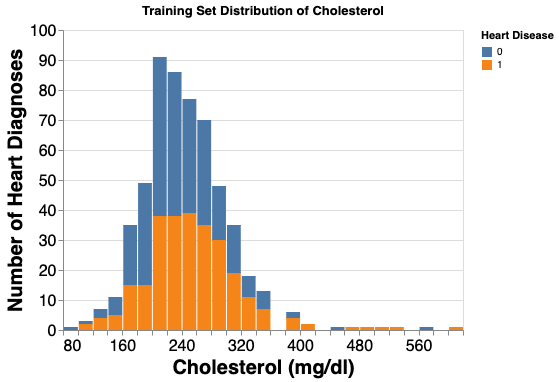

In [7]:
chol_plot

Figure 1 (above): A plot showing the distribution of cholesterol within the training data set, which are colored by diagnosis (Blue = No Heart Disease, Orange = Heart Disease).

As seen in the plot above, in patients with moderate levels of cholesterol, heart disease is not seemingly strongly correlated with cholesterol (there are roughly the same number of diseased and not diseased patients with average cholesterol levels). However, in higher cholesterols (greater than 320mg/dl especially), there is a potential connection between cholesterol and the presence of heart disease. For this reason, serum cholesterol will be included in the classifier.

In [8]:
restbp_plot = (
    alt.Chart(heart_data_training, title="Training Set Distribution of Resting Blood Pressure")
    .mark_bar()
    .encode(
        x=alt.X("RestingBP",bin=alt.Bin(maxbins=30),title="Resting Blood Pressure (mm/Hg)",scale=alt.Scale(zero=False)),
        y=alt.Y("count(HeartDisease)",title="Number of Heart Diagnoses"),
        fill=alt.Fill("HeartDisease:N", title="Heart Disease")
    )
    .configure_axis(titleFontSize=20,labelFontSize=16)

)

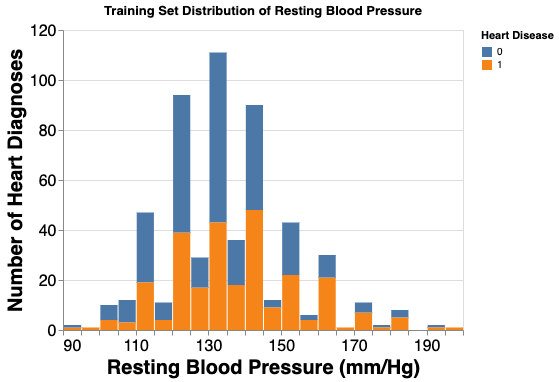

In [9]:
restbp_plot

Figure 2 (above): A plot showing the distribution of resting blood pressure within the training data set, which are colored by diagnosis (Blue = No Heart Disease, Orange = Heart Disease).

As seen in the plot above, in patients with moderate resting blood pressures, heart disease is not seemingly strongly correlated with resting blood pressures (there are roughly the same number of diseased and not diseased patients with average resting blood pressures levels). However, in higher resting blood pressures (greater than 135mm/Hg especially), there is a potential connection between resting blood pressures and the presence of heart disease. For this reason, resting blood pressures will be included in the classifier.

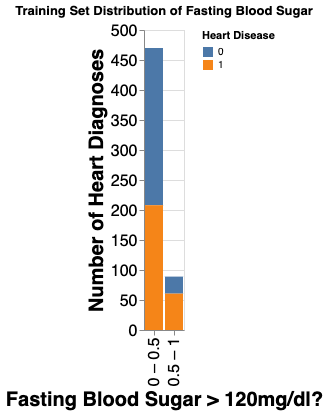

In [10]:
fastbs_plot = (
    alt.Chart(heart_data_training, title="Training Set Distribution of Fasting Blood Sugar")
    .mark_bar()
    .encode(
        x=alt.X("FastingBS:N", bin=alt.Bin(maxbins=2), title="Fasting Blood Sugar > 120mg/dl?"),
        y=alt.Y("count(HeartDisease)",title="Number of Heart Diagnoses"),
        fill=alt.Fill("HeartDisease:N", title="Heart Disease")
    )
    .configure_axis(titleFontSize=20,labelFontSize=16)
)
fastbs_plot

Figure 3 (above): A plot showing the distribution of fasting blood sugar within the training data set, which are colored by diagnosis (Blue = No Heart Disease, Orange = Heart Disease). The 0-0.5 column indicates the fasting blood sugar is below 120mg/dl, whereas the 0.5-1 column indicates it is above 120mg/dl.

As seen in the plot above, there seems to be a connection between high blood sugar and presence of heart disease. There seems to be a higher proportion of heart disease when the patient's fasting blood sugar is higher than 120mg/dl than when it is under 120mg/dl. For this reason, Fasting Blood Sugar will be included in the classifier.

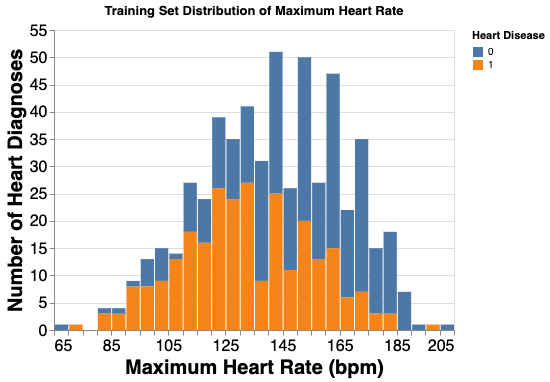

In [11]:
maxhr_plot = (
    alt.Chart(heart_data_training, title="Training Set Distribution of Maximum Heart Rate")
    .mark_bar()
    .encode(
        x=alt.X("MaxHR",bin=alt.Bin(maxbins=30),title="Maximum Heart Rate (bpm)",scale=alt.Scale(zero=False)),
        y=alt.Y("count(HeartDisease)",title="Number of Heart Diagnoses"),
        fill=alt.Fill("HeartDisease:N", title="Heart Disease")
    )
    .configure_axis(titleFontSize=20,labelFontSize=16)

)
maxhr_plot

Figure 4 (above): A plot showing the distribution of maximum heart rate within the training data set, which are colored by diagnosis (Blue = No Heart Disease, Orange = Heart Disease).

As seen in the plot above, there seems to be a connection between maximum heart rate and presence of heart disease. It seems that the higher the maximum heart rate, the lower the proportion of patients afflicted with heart disease. So, generally, it seems that those with heart diseases have lower maximum heart rates. For this reason, maximum heart rate will be included in the classifier.

### Methods & Results

As our predictive question is a classification problem (classify a patient to have heart disease or not), we will be using the K-nearest neighbors classification algorithm. We will be tuning the classifier using 5-fold cross validation and grid searching K values from 2 to 50 in order to find the optimal K value. The model will be evaluated on the testing data, which is 25% of the original data, and we will be analyzing the mean test scores and the confusion matrix. We will be visualizing a graph of the mean test score vs K values.

Regarding our choice of predictor variables, we have selected to use RestingBP, Cholesterol, FastingBS, and MaxHR due to their apparent correlation with Heart Disease as seen in our EDA. For the variables Age, Sex, and ExerciseAngia, we have found professional sources that suggest a possible link between these variables and heart disease. These findings are listed below with their corresponding citation.

**Age:** Age is an independent risk factor for heart diseases (Jennifer L. Rodgers et al., 2019)

**Sex:** Women have been shown to be more susceptible to cardiovascular diseases. Factors like serum cholesterol, blood pressure seemingly increase with age in women (Pekka Jousilahti et al., 1999).

**Exercise angina:** The occurrence of acute angina and sudden death from CVD-related issues is highest in those who are not physically active (Paul D. Thompson et al., 2007).


### Creating the KNN Classifier

Before feeding the data into the classifier, we first pass through the binary variables and apply the StandardScaler transformer on the remaining predictor variables. Standardizing the numerical variables will make sure that the data will be on a comparable scale and individual attributes will not disproportionately affect the distance calculations used in the KNN classifier.

In [12]:
#Building the preprocessor
heart_preprocessor = make_column_transformer(
        (
        "passthrough",
        [
            "Sex",
            "FastingBS",
            "ExerciseAngina",
        ],
    ),
    (StandardScaler(), ["Age","RestingBP","Cholesterol","MaxHR"]),
)
heart_preprocessor

ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                 ['Sex', 'FastingBS', 'ExerciseAngina']),
                                ('standardscaler', StandardScaler(),
                                 ['Age', 'RestingBP', 'Cholesterol', 'MaxHR'])])

We perform a grid search with 5-fold cross validation for K values between 2 and 50 in order to find the one that is the most accurate.

In [13]:
param_grid = {
    "kneighborsclassifier__n_neighbors": range(2, 50, 1),
}
heart_tune_pipe = make_pipeline(heart_preprocessor, KNeighborsClassifier())

In [14]:
knn_tune_grid = GridSearchCV(
    estimator=heart_tune_pipe, param_grid=param_grid, cv=5,
)
knn_tune_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         ['Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(2, 50)})

The model is fitted to the training data and the resulting training accuracies can be outputted.

In [15]:
X_tune = heart_data_training[["Age","Sex","RestingBP","Cholesterol","FastingBS","MaxHR","ExerciseAngina"]]
y_tune = heart_data_training["HeartDisease"]

knn_model_grid = knn_tune_grid.fit(X_tune, y_tune)

accuracies_grid = pd.DataFrame(knn_model_grid.cv_results_)

knn_model_grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('passthrough',
                                                                         'passthrough',
                                                                         ['Sex',
                                                                          'FastingBS',
                                                                          'ExerciseAngina']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'MaxHR'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(2, 50)})

In [16]:
accuracies_grid.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031764,0.015895,0.066685,0.022594,2,{'kneighborsclassifier__n_neighbors': 2},0.714286,0.660714,0.642857,0.758929,0.720721,0.699501,0.042222,48
1,0.045442,0.021630,0.035564,0.002658,3,{'kneighborsclassifier__n_neighbors': 3},0.750000,0.732143,0.678571,0.750000,0.720721,0.726287,0.026331,47
2,0.043130,0.023570,0.033730,0.002448,4,{'kneighborsclassifier__n_neighbors': 4},0.776786,0.705357,0.705357,0.794643,0.756757,0.747780,0.036654,16
3,0.030022,0.016250,0.041242,0.020374,5,{'kneighborsclassifier__n_neighbors': 5},0.732143,0.732143,0.705357,0.750000,0.720721,0.728073,0.014724,46
4,0.040931,0.022995,0.038048,0.003976,6,{'kneighborsclassifier__n_neighbors': 6},0.750000,0.732143,0.696429,0.794643,0.729730,0.740589,0.032093,30


Table 4 (above): This table shows the results of the accuracies grid. By plotting the mean test score (accuracy) and the number of neighbours (*K*) from this table, we will be able to find the *K* that will maximize our model's accuracy.

/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


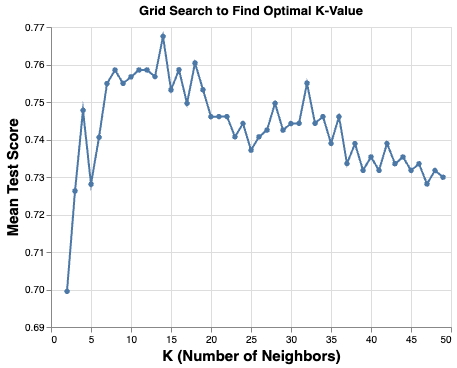

In [17]:
accuracy_versus_k_grid = (
    alt.Chart(accuracies_grid, title="Grid Search to Find Optimal K-Value")
    .mark_line(point=True)
    .encode(
        x=alt.X(
            "param_kneighborsclassifier__n_neighbors",
            title="K (Number of Neighbors)",
            scale=alt.Scale(zero=False),
        ),
        y=alt.Y(
            "mean_test_score", 
            title="Mean Test Score", 
            scale=alt.Scale(zero=False)
        ),
    )
    .configure_axis(labelFontSize=10, titleFontSize=15)
    .properties(width=400, height=300)
)
accuracy_versus_k_grid

Figure 5 (above): This is a plot of the mean test score (average accuracy) and the number of neighbours used in the model. By finding the *K* with the highest mean test score, we will know the number of neighbours we should use in our model to maximize accuracy. Based on this graph, it seems that the K value with the highest mean test score is K = 14.

In [18]:
accuracies_grid[["param_kneighborsclassifier__n_neighbors","mean_test_score"]].groupby("mean_test_score").max().tail(1)

,param_kneighborsclassifier__n_neighbors
mean_test_score,
0.767503,14


Table 5 (above): This simple, single-rowed table shows the K-value with the highest average accuracy. As seen in this table and Figure 5, the model has the highest mean test score when *K*=14, so we should use 14 neighbours in our final model to maximize our model's accuracy.

### Building the Final Model

We will use the previously determined optimal K value (14) to build out a new pipeline and apply the test data set on it to see how well our model deals with new data.

In [23]:
#Heart Fit
knn_spec = KNeighborsClassifier(n_neighbors=14)
X = heart_data_training[["Age","Sex","RestingBP","Cholesterol","FastingBS","MaxHR","ExerciseAngina"]]
y = heart_data_training["HeartDisease"]

heart_fit = make_pipeline(heart_preprocessor, knn_spec).fit(X, y)
heart_fit

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['Sex', 'FastingBS',
                                                   'ExerciseAngina']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['Age', 'RestingBP',
                                                   'Cholesterol', 'MaxHR'])])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=14))])

In [20]:
#Applying to Test Set
heart_test_predictions = heart_fit.predict(heart_data_testing[["Age","Sex","RestingBP","Cholesterol","FastingBS","MaxHR","ExerciseAngina"]])
heart_test_predictions = pd.concat(
    [
        heart_data_testing.reset_index(drop=True),
        pd.DataFrame(heart_test_predictions, columns=["predicted"]),
    ],
    axis=1,
)
heart_test_predictions.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,HeartDisease,predicted
0,52,1,125,212,0,168,0,1,0
1,47,1,110,249,0,150,0,0,0
2,65,1,138,282,1,174,0,1,0
3,62,1,120,220,0,86,0,0,0
4,71,0,160,302,0,162,0,0,0


Table 6 (above): This is a glimpse at our final model's accuracy at predicting the presence or absence of heart disease. The "HeartDisease" column is the "true" column, containing the real values that were measured, while the "predicted" column shows the presence/absence predictions the model made. (Recall that 1 = Presence of Heart Disease, 0 = Absence of Heart Disease)

### Accuracy and Confusion Matrix

In [21]:
#Accuracy
X_test = heart_test_predictions[["Age","Sex","RestingBP","Cholesterol","FastingBS","MaxHR","ExerciseAngina"]]
y_test = heart_test_predictions["HeartDisease"]

heart_prediction_accuracy = heart_fit.score(X_test, y_test)
heart_prediction_accuracy

0.7647058823529411

The value above states that the final model had a prediction accuracy of 0.7647, or about 76.47% on the test data.

As a baseline, we will compare our model's accuracy with the accuracy of a majority classifier.

In [24]:
heart_test_predictions["HeartDisease"].value_counts(normalize=True)

0    0.534759
1    0.465241
Name: HeartDisease, dtype: float64

Recall that 1 = Presence of Heart Disease, 0 = Absence of Heart Disease. The majority classifier will always guess "No Heart Disease", which gives it a 53% accuracy on the test data set. The accuracy of our model is significantly greater than the majority classifier's accuracy.


We will also look at the confusion matrix of our model to determine the number of false positive and false negative predictions.

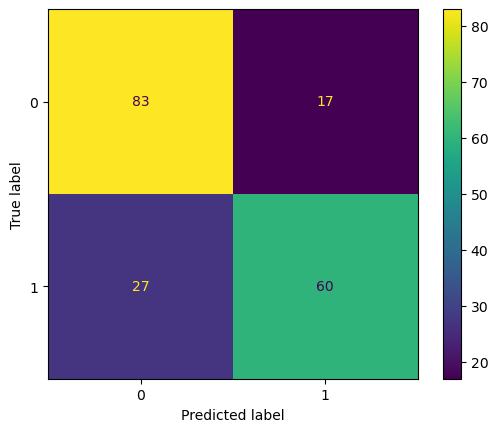

In [22]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
heart_mat = confusion_matrix(
    heart_test_predictions["HeartDisease"],  # true labels
    heart_test_predictions["predicted"],  # predicted labels
    labels=heart_fit.classes_, # specify the label for each class
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=heart_mat, display_labels=heart_fit.classes_
)
disp.plot()

Figure 6 (above): Above is a confusion matrix of our model's predictions. As seen in the plot, 60 out of a total of 87 cases of heart disease were correctly predicted by the model, and 83 out of 100 instances of an absence of heart disease were correctly predicted. This consequently means that there were 17 false positive predictions and 27 false negative predictions. (Recall that 1 = Presence of Heart Disease, 0 = Absence of Heart Disease)

### Discussion

Our KNN classifier with K = 14 achieved 76% accuracy. This is in line with the best training accuracy (76%) and indicates that our model is neither overfitting nor underfitting. When compared to a standard majority classifier, our model performed much better (76% vs 53% accuracy), suggesting that our KNN classifier is extracting some useful information from our predictor variables. 


According to the confusion matrix, when our model is incorrect, it is almost twice as likely to be a false negative rather than a false positive. One possible explanation is that since there are more “Absence of Heart Disease” labels in the data set, it is more likely for the KNN classifier to output a “No Heart Disease” result. This is not ideal as when dealing with health outcomes, it is generally better to err on the side of caution. One possible course of action to remedy this issue is to obtain a more even spread of data points between patients with and without heart disease. It is also possible to explore other different predictor variables in the data set to see if any of those are linked to heart disease.

### Expected Outcomes and Significance

The findings are in line with our expectations of being able to predict the existence of heart disease in a patient with significantly more accuracy when compared to using a majority classifier.

The impact of such findings will be significant. Cardiovascular diseases are the largest contributor to global deaths; being able to accurately predict their presence could help those afflicted get treatment earlier. This would also free up valuable time that doctors would have to spend to diagnose patients.

Future questions that may result from this project include determining which subset of the 76 predictor variables are the most important for heart disease prediction. This can also lead to the development of models that can give early warnings to at-risk individuals.

### References

* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science. Retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

* Fedesoriano. (September 2021). Heart Failure Prediction Dataset. Retrieved from https://www.kaggle.com/fedesoriano/heart-failure-prediction.

* Jousilahti, P., Vartiainen, E., Tuomilehto , J., & Puska, P. (1999, March 9). Sex, age, cardiovascular risk factors, and coronary heart disease. Retrieved from  https://www.ahajournals.org/doi/10.1161/01.CIR.99.9.1165

* Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019, April 27). Cardiovascular risks associated with gender and aging. Journal of cardiovascular development and disease. Retrieved March 11, 2023, from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6616540/

* Thompson, P. D., Franklin, B. A., Balady, G. J., Blair, S. N., Corrado, D., EstesIII, N. A. M., Fulton, J. E., Gordon, N. F., Haskell, W. L., Link, M. S., Maron, B. J., Mittleman, M. A., Pelliccia, A., Wenger, N. K., Willich, S. N., & Costa, F. (2007, April 27). Exercise and acute cardiovascular events | circulation. Retrieved March 11, 2023, from https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.107.181485

#### With special thanks to the data collectors from each institution:
1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.